# Notebook to calculate and plot the correlation and bias functions

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import Corrfunc
from Corrfunc.theory.xi import xi

In [2]:
fname_on='/data/desi/common/astrid/spectra_ASTRID_z2.5_500x500x2500.hdf5'

In [3]:
with h5py.File(fname_on,'r') as f:
    tau_on = f['tau/H/1/1215'][:]
    colden = f['colden']['H/1'][:]
    axes = f['spectra/axes'][:]
    # (x,y,z) start of the skewers, in kpc/h
    cofm_hkpc = f['spectra/cofm'][:]

In [4]:
L_hMpc=250
Nsk=int(np.sqrt(colden.shape[0]))
Np=int(colden.shape[1])
dz_hMpc=L_hMpc/Np
dxy_hMpc=L_hMpc/Nsk
max_colden=np.max(colden.reshape([Nsk,Nsk,Np]),axis=2)

def skewer_index(ix, iy):
    return ix*Nsk+iy
    
def skewer_ix_iy(isk):
    """Given the global index, return the (ix, iy) indices of a skewer"""
    ix=isk//Nsk
    iy=isk-ix*Nsk    
    return ix, iy

In [5]:
def HCDs_coords(mincolden, maxcolden):
    
    L_hMpc = 250
    Nsk = int(np.sqrt(colden.shape[0]))  # 500
    Np = int(colden.shape[1])            # 2500
    dz_hMpc = L_hMpc / Np
    dxy_hMpc = L_hMpc / Nsk

    # Build i and j grids
    i_vals = np.arange(Nsk**2)
    j_vals = np.arange(Np)
    i_grid, j_grid = np.meshgrid(i_vals, j_vals, indexing='ij')  # shape (Nsk^2, Np)

    # Mask where column density is in desired range
    mask = (colden > mincolden) & (colden < maxcolden)

    # Flatten everything where mask is True
    i_valid = i_grid[mask]
    j_valid = j_grid[mask]

    # Compute ix, iy from i
    ix = i_valid % Nsk
    iy = i_valid // Nsk

    # Final coordinates
    x = dxy_hMpc * ix
    y = dxy_hMpc * iy
    z = dz_hMpc * j_valid

    return {
        "x": x,
        "y": y,
        "z": z
    }


## Correlation function test

In [11]:
coords = HCDs_coords(1e22, 1e23)

In [12]:
binf = np.logspace(np.log10(2), np.log10(20), 10)
x=coords["x"]
y=coords["y"]
z=coords["z"]
func = Corrfunc.theory.xi(boxsize=250.0, nthreads=1, binfile=binf, X=x,Y=y,Z=z, output_ravg=True)

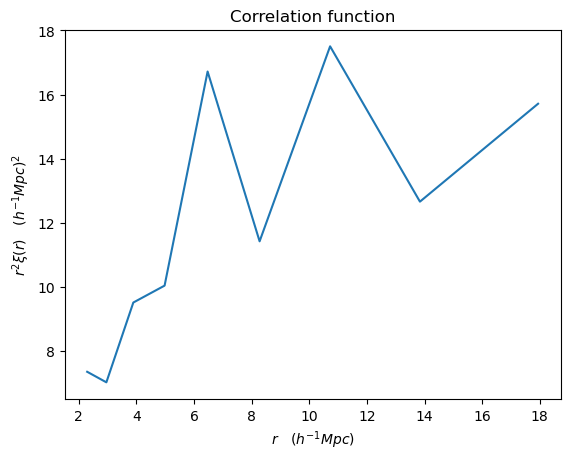

In [13]:
plt.plot(func["ravg"], func["ravg"]**2 * func["xi"])
plt.title("Correlation function")
plt.xlabel(r"$r\quad(h^{-1}Mpc)$")
plt.ylabel(r"$r^2\xi(r)\quad(h^{-1}Mpc)^2$")
plt.show()

## Calculate the correlation function for diferent HCDs

In [ ]:
coords_LLSs = HCDs_coords(1.6e17, 1e19)
coords_subDLAs = HCDs_coords(1e19, 2e20)
coords_smallDLAs = HCDs_coords(2e20, 1e21)
coords_largeDLAs = HCDs_coords(1e21, 1e25)

In [15]:
binf = np.logspace(np.log10(2), np.log10(20), 10)
func_LLSs = Corrfunc.theory.xi(boxsize=250.0, nthreads=1, binfile=binf, X=coords_LLSs["x"],Y=coords_LLSs["y"],Z=coords_LLSs["z"], output_ravg=True)
func_subDLAs = Corrfunc.theory.xi(boxsize=250.0, nthreads=1, binfile=binf, X=coords_subDLAs["x"],Y=coords_subDLAs["y"],Z=coords_subDLAs["z"], output_ravg=True)
func_smallDLAs = Corrfunc.theory.xi(boxsize=250.0, nthreads=1, binfile=binf, X=coords_smallDLAs["x"],Y=coords_smallDLAs["y"],Z=coords_smallDLAs["z"], output_ravg=True)
func_largeDLAs = Corrfunc.theory.xi(boxsize=250.0, nthreads=1, binfile=binf, X=coords_largeDLAs["x"],Y=coords_largeDLAs["y"],Z=coords_largeDLAs["z"], output_ravg=True)

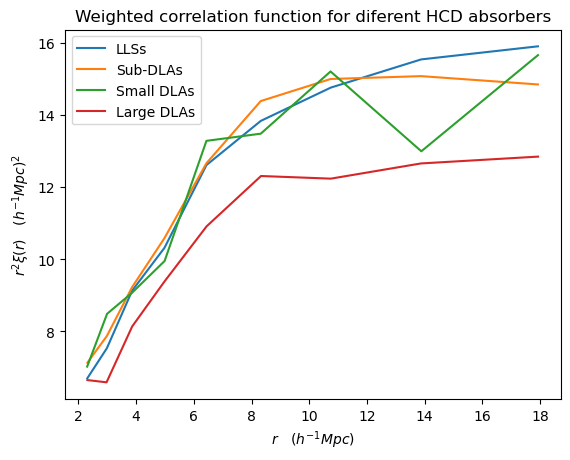

In [16]:
plt.plot(func_LLSs["ravg"], func_LLSs["ravg"]**2 * func_LLSs["xi"], label = "LLSs")
plt.plot(func_subDLAs["ravg"], func_subDLAs["ravg"]**2 * func_subDLAs["xi"], label = "Sub-DLAs")
plt.plot(func_smallDLAs["ravg"], func_smallDLAs["ravg"]**2 * func_smallDLAs["xi"], label = "Small DLAs")
plt.plot(func_largeDLAs["ravg"], func_largeDLAs["ravg"]**2 * func_largeDLAs["xi"], label = "Large DLAs")
plt.legend()
plt.title("Weighted correlation function for diferent HCD absorbers")
plt.xlabel(r"$r\quad(h^{-1}Mpc)$")
plt.ylabel(r"$r^2\xi(r)\quad(h^{-1}Mpc)^2$")
plt.savefig("r2corrfunc.png")

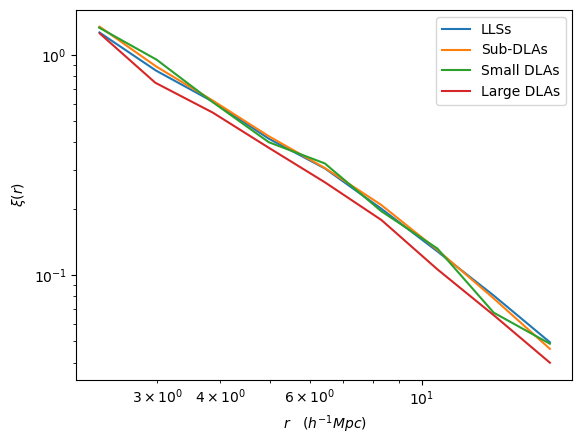

In [17]:
plt.plot(func_LLSs["ravg"], func_LLSs["xi"], label = "LLSs")
plt.plot(func_subDLAs["ravg"], func_subDLAs["xi"], label = "Sub-DLAs")
plt.plot(func_smallDLAs["ravg"], func_smallDLAs["xi"], label = "Small DLAs")
plt.plot(func_largeDLAs["ravg"], func_largeDLAs["xi"], label = "Large DLAs")
plt.xscale("log")
plt.yscale("log")
plt.legend()
#plt.title("Correlation function for diferent HCD absorbers")
plt.xlabel(r"$r\quad(h^{-1}Mpc)$")
plt.ylabel(r"$\xi(r)$")
plt.savefig("corrfunc.png")

## Calculate dm_2pcf

In [18]:
file = np.load("lin2pcf_2.5_cosmo_astrid.npy", allow_pickle=True).item()

In [19]:
dm_2pcf_LLSs = np.interp(func_LLSs["ravg"], file["r"], file["xi"])
dm_2pcf_subDLAs = np.interp(func_subDLAs["ravg"], file["r"], file["xi"])
dm_2pcf_smallDLAs = np.interp(func_smallDLAs["ravg"], file["r"], file["xi"])
dm_2pcf_largeDLAs = np.interp(func_LLSs["ravg"], file["r"], file["xi"])

In [20]:
ratio_LLSs = func_LLSs["xi"]/dm_2pcf_LLSs
ratio_subDLAs = func_subDLAs["xi"]/dm_2pcf_subDLAs
ratio_smallDLAs = func_smallDLAs["xi"]/dm_2pcf_smallDLAs
ratio_largeDLAs = func_largeDLAs["xi"]/dm_2pcf_largeDLAs

In [21]:
selected_xi_LLSs = ratio_LLSs[func_LLSs["ravg"] > 10]
selected_xi_subDLAs = ratio_subDLAs[func_subDLAs["ravg"] > 10]
selected_xi_smallDLAs = ratio_smallDLAs[func_smallDLAs["ravg"] > 10]
selected_xi_largeDLAs = ratio_largeDLAs[func_largeDLAs["ravg"] > 10]

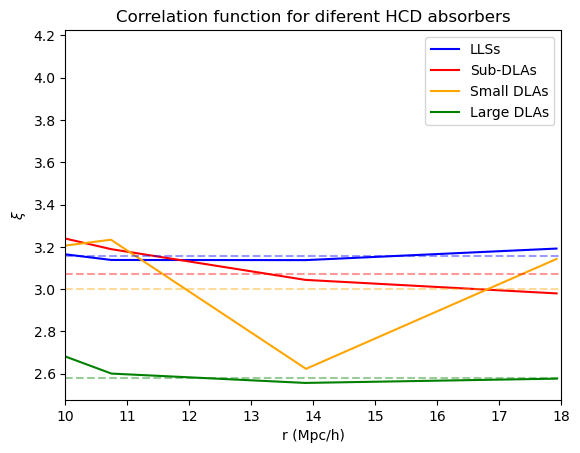

In [22]:
plt.plot(func_LLSs["ravg"], ratio_LLSs, color = 'b', label = "LLSs")
plt.plot(func_subDLAs["ravg"], ratio_subDLAs, color = 'r', label = "Sub-DLAs")
plt.plot(func_smallDLAs["ravg"], ratio_smallDLAs, color = 'orange', label = "Small DLAs")
plt.plot(func_largeDLAs["ravg"], ratio_largeDLAs, color = 'g', label = "Large DLAs")
plt.xlim(10,18)
plt.axhline(y=np.mean(selected_xi_LLSs), color='b', linestyle='--', alpha = 0.4)
plt.axhline(y=np.mean(selected_xi_subDLAs), color='r', linestyle='--', alpha = 0.4)
plt.axhline(y=np.mean(selected_xi_smallDLAs), color='orange', linestyle='--', alpha = 0.4)
plt.axhline(y=np.mean(selected_xi_largeDLAs), color='g', linestyle='--', alpha = 0.4)
plt.legend()
plt.title("Correlation function for diferent HCD absorbers")
plt.xlabel("r (Mpc/h)")
plt.ylabel(r"$\xi$")
plt.show()

## Calculate bias function

In [23]:
coldenLLSs = np.array([])
for i in range(len(coords_LLSs["x"])):
    coldenLLSs = np.append(coldenLLSs, max_colden[int(coords_LLSs["x"][i]/dxy_hMpc),int(coords_LLSs["y"][i]/dxy_hMpc)])
meanLLSs=np.mean(coldenLLSs)

coldensubDLAs = np.array([])
for i in range(len(coords_subDLAs["x"])):
    coldensubDLAs = np.append(coldensubDLAs, max_colden[int(coords_subDLAs["x"][i]/dxy_hMpc),int(coords_subDLAs["y"][i]/dxy_hMpc)])
meansubDLAs=np.mean(coldensubDLAs)

coldensmallDLAs = np.array([])
for i in range(len(coords_smallDLAs["x"])):
    coldensmallDLAs = np.append(coldensmallDLAs, max_colden[int(coords_smallDLAs["x"][i]/dxy_hMpc),int(coords_smallDLAs["y"][i]/dxy_hMpc)])
meansmallDLAs=np.mean(coldensmallDLAs)

coldenlargeDLAs = np.array([])
for i in range(len(coords_largeDLAs["x"])):
    coldenlargeDLAs = np.append(coldenlargeDLAs, max_colden[int(coords_largeDLAs["x"][i]/dxy_hMpc),int(coords_largeDLAs["y"][i]/dxy_hMpc)])
meanlargeDLAs=np.mean(coldenlargeDLAs)

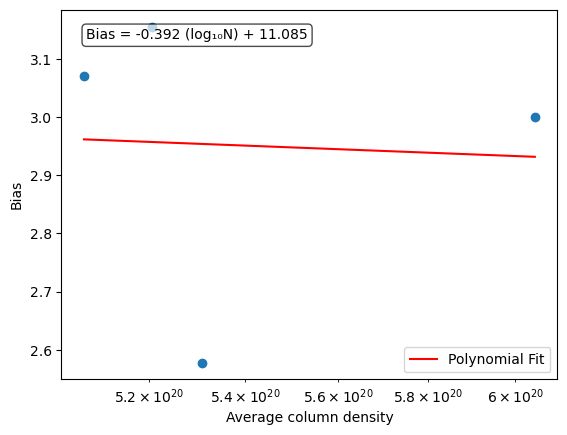

[-0.39232532 11.08482765]


In [24]:
biasHCDs = np.array([np.mean(selected_xi_LLSs), np.mean(selected_xi_subDLAs), np.mean(selected_xi_smallDLAs), np.mean(selected_xi_largeDLAs)])
CD = np.array([meanLLSs, meansubDLAs, meansmallDLAs, meanlargeDLAs])

plt.scatter(CD, biasHCDs)
plt.xlabel("Average column density")
plt.ylabel("Bias")
plt.xscale("log")

coeffs = np.polyfit(np.log10(CD), biasHCDs, 1)
logx_fit = np.linspace(np.log10(CD).min(), np.log10(CD).max(), 200)
y_fit = np.polyval(coeffs, logx_fit)
x_fit = 10 ** logx_fit


plt.plot(x_fit, y_fit, color='red', label='Polynomial Fit')


a, b = coeffs
equation = f'Bias = {a:.3f} (log₁₀N) + {b:.3f}'

plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.legend(loc='lower right')
plt.savefig("bias.png")
plt.show()

print(coeffs)